# DATASET DOWNLOAD


# Import

In [286]:
from pathlib import Path
from bs4 import BeautifulSoup
from tqdm import tqdm
from joblib import Parallel, delayed
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

#nltk.download('averaged_perceptron_tagger')
#nltk.download("punkt")
#nltk.download("punkt_tab")
#nltk.download("wordnet")
#nltk.download("omw-1.4")
#nltk.download("stopwords")

# Extracting features
This part was made analyzing the content of the HTML end extracting what we considered the most important sections of the file

In [287]:
def html_to_text(path: Path):
 
    html = path.read_text(encoding="utf-8", errors="ignore")
    soup = BeautifulSoup(html, features="lxml")

    doc_parts = []

    # title
    div_title = soup.find("div", class_="BookPageTitleSection")
    if div_title:
        titles = div_title.find_all(recursive=False)
        for title in titles:
            doc_parts.append(title.get_text(strip=True))

    # desc
    div_desc = soup.find("div", class_="BookPageMetadataSection__description")
    if div_desc:
        desc_cell = div_desc.find(class_="Formatted")
        if desc_cell:
            doc_parts.append(desc_cell.get_text(separator=" ", strip=True))

    # author name
    div_auth = soup.find("div", class_="AuthorPreview")
    if div_auth:
        auth_name_tag = div_auth.find(class_="ContributorLink__name")
        if auth_name_tag:
            doc_parts.append(auth_name_tag.get_text(strip=True))

    # awards
    div_work = soup.find("div", class_="WorkDetails")
    if div_work:
        awards_tag = div_work.find(class_="TruncatedContent__text")
        if awards_tag:
            awards = awards_tag.get_text(separator=" ", strip=True)
            doc_parts.append(awards)

    # author biograpgy
    div_bio = soup.find("div", class_="PageSection")
    if div_bio:
        bio_tag = div_bio.find("div", class_="DetailsLayoutRightParagraph__widthConstrained")
        if bio_tag:
            bio = bio_tag.text
            doc_parts.append(bio)

    # correlated books
    div_relatedbooks = soup.find("div", class_="BookPage__relatedTopContent")
    if div_relatedbooks:
        div_carousel = div_relatedbooks.find(class_="Carousel--sliderWrapper")
        if div_carousel:
            related_books_container = div_carousel.find_all("li")
            for book in related_books_container:
                book_title_tag = book.find(class_="BookCard__title")
                if book_title_tag:
                    doc_parts.append(book_title_tag.get_text(strip=True))

    # reviews
    div_reviews_list = soup.find_all("div", class_="ReviewsList")
    if len(div_reviews_list) > 1:
        div_reviews = div_reviews_list[1]
        div_reviews_children = div_reviews.find_all("div", recursive=False)

        if len(div_reviews_children) > 1:
            div_list = div_reviews_children[1]

            for ad_class in div_list.find_all(class_="Ad"):
                ad_class.decompose()

            div_review_list = div_list.find_all("div", recursive=False)
            for div_review in div_review_list:
                review_tag = div_review.find(class_="TruncatedContent__text")
                if review_tag:
                    doc_parts.append(review_tag.get_text(separator=" ", strip=True))


    final_doc = " ".join(doc_parts)
    return {
        "ID": path.stem,
        "text": final_doc
    }

files = list(Path("adm-2025-unsupervised-book-grouping/pages").glob("*.html"))
docs = Parallel(n_jobs=-1)(delayed(html_to_text)(p) for p in tqdm(files))
texts = [d["text"] for d in docs]

100%|██████████| 1934/1934 [00:50<00:00, 38.01it/s]


# TF-IDF + LSA

we are going to remove stopwords not only from english because some reviews in the html are written in a different language than english.

We see the limit of following this approach because books of the same genre but different language will end up in two different clusters as the tf-idf relies on exact keyword matching

In [288]:
stop_en = set(stopwords.words("english"))
stop_it = set(stopwords.words("italian"))
stop_es = set(stopwords.words("spanish"))
stop_fr = set(stopwords.words("french"))
stop_de = set(stopwords.words("german"))
stemmer = SnowballStemmer("english")

custom_stops = {
    'book', 'books', 'story', 'stories', 'read', 'reading', 'reader', 'author', 
    'page', 'pages', 'plot', 'novel', 'series',
    'libro', 'libri', 'storia', 'leggere', 'lettura', 'autore', 'pagine', 'trama', 'romanzo'
}

FULL_STOPWORDS = set.union(stop_en, stop_it, stop_es, stop_fr, stop_de, custom_stops)

## Preprocessing

In [289]:
def preprocessing_tfidf(text):
    """
    1. Tokenization and lowercase.
    2. removing non-alphabetic characters.
    3. removig stopwords.
    4. Stemming with snowball stemmer.
    """
    tokens = word_tokenize(text.lower())
    
    tokens = [re.sub(r"[^a-z]", "", t) for t in tokens]
    
    
    clean_tokens = []
    for word in tokens:
        if len(word) > 2 and word not in FULL_STOPWORDS:
            clean_tokens.append(stemmer.stem(word))
            
    return " ".join(clean_tokens)

print("Preprocessing...")
processed_texts = [preprocessing_tfidf(t) for t in tqdm(texts)]

print(f"Done: {processed_texts[0][:100]}...")

Preprocessing...


100%|██████████| 1934/1934 [01:50<00:00, 17.52it/s]

Done: thief librarian note altern cover edit found nazi germani countri hold breath death never busier bus...


## Feature Extraction

In [290]:

tfidf = TfidfVectorizer(
    max_features=5000,
    max_df=0.50,
    min_df=7,
    ngram_range=(1, 2)
)

X_sparse = tfidf.fit_transform(processed_texts)
print(f"Shape TF-IDF matrix: {X_sparse.shape}")

Shape TF-IDF matrix: (1934, 5000)


## LSA
Way better than PCA for sparse matrix

In [291]:
print("Reducing dimensionality")

n_components = 10
svd = TruncatedSVD(n_components=n_components, random_state=42)
normalizer = Normalizer(copy=False) 

lsa_pipeline = make_pipeline(svd, normalizer)
X_lsa = lsa_pipeline.fit_transform(X_sparse)

var_explained = svd.explained_variance_ratio_.sum()
print(f"n_components: {n_components}    variance: {var_explained:.2%}")

Reducing dimensionality
n_components: 10    variance: 8.78%


## Elbow method to find the best k

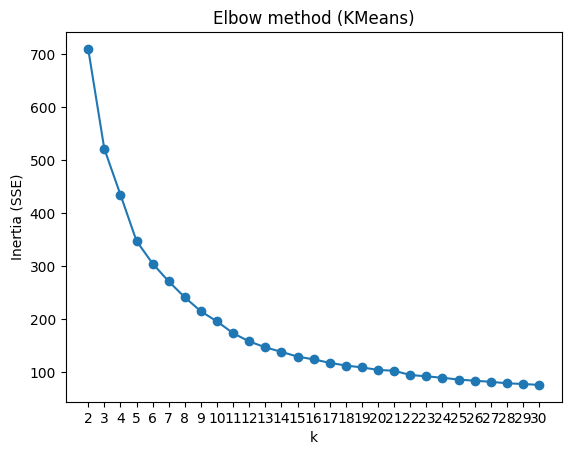

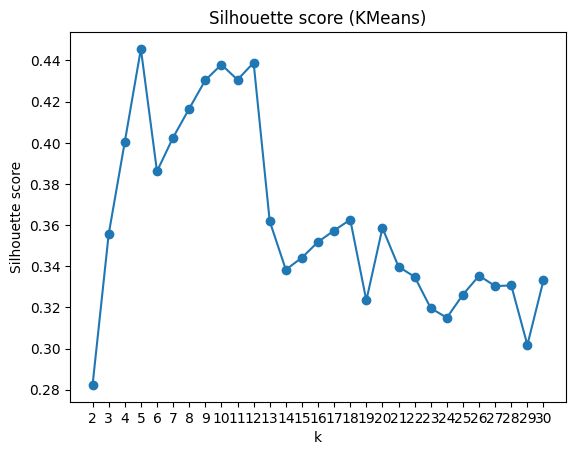


--- TOP 3 K (SILHOUETTE) ---
k = 5  score = 0.4456
k = 12  score = 0.4390
k = 10  score = 0.4380


In [292]:

def kmeans_elbow_silhouette(
    X,
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None,
):
    n_samples = X.shape[0]
    if n_samples < 3:
        raise ValueError("We need at least 3 samples.")

    k_max = min(k_max, n_samples - 1)
    ks = list(range(k_min, k_max + 1))

    inertias = []
    silhouettes = []

    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)

        if sample_size_for_silhouette is not None and n_samples > sample_size_for_silhouette:
            sil = silhouette_score(X, labels, sample_size=sample_size_for_silhouette, random_state=random_state)
        else:
            sil = silhouette_score(X, labels)
        silhouettes.append(sil)

    return np.array(ks), np.array(inertias), np.array(silhouettes)


ks, inertias, sils = kmeans_elbow_silhouette(
    X_lsa,
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None
)

# --- PLOT ELBOW ---
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans)")
plt.xticks(ks)
plt.show()

# --- PLOT SILHOUETTE ---
plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score (KMeans)")
plt.xticks(ks)
plt.show()

top_indices = np.argsort(sils)[::-1]

print("\n--- TOP 3 K (SILHOUETTE) ---")
for i in range(3):
    idx = top_indices[i]
    print(f"k = {ks[idx]}  score = {sils[idx]:.4f}")

## Clustering and score

In [293]:
k = 9
print(f"Clustering with K={k}...")

kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
tfidf_labels = kmeans.fit_predict(X_lsa)

baseline_score = silhouette_score(X_lsa, tfidf_labels)

print(f"BASELINE SCORE (TF-IDF + LSA): {baseline_score:.4f}")

Clustering with K=9...
BASELINE SCORE (TF-IDF + LSA): 0.4288


## Cluster analysis

In [294]:
print("Top Keywords per Cluster:")

original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(k):
    print(f"\nCluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :12]]
    print(", ".join(top_terms))

Top Keywords per Cluster:

Cluster 0:
selfhelp, habit, advic, spiritu, psycholog, practic, law, goal, scienc, social, guid, research

Cluster 1:
fantasi, king, soldier, american, histor, shakespear, sister, german, queen, militari, polit, jack

Cluster 2:
vietnam, soldier, german, american, militari, nazi, histor, armi, camp, wwii, vietnames, germani

Cluster 3:
fantasi, king, queen, heroin, kingdom, demon, sister, shakespear, princ, rose, friendship, jace

Cluster 4:
vampir, darren, fantasi, twilight, clair, raven, paranorm, witch, lestat, bella, vlad, king

Cluster 5:
alex, alex cross, patterson, rider, cross, jame, ava, spi, killer, jordan, jack, simon

Cluster 6:
poirot, christi, agatha, holm, agatha christi, detect, bosch, sherlock, harri, hercul poirot, hercul, crime

Cluster 7:
sooki, bosch, anita, harri, kinsey, connelli, harri bosch, eric, vampir, detect, investig, grafton

Cluster 8:
reacher, jack, jack reacher, lee child, lee, clanci, thriller, militari, fantasi, town, bosch

In the end we managed to get a score on the public leaderboard of 0.43 using this approach

# Transformer
We chose Transformer models to capture the semantic meaning and context of the text, rather than relying only on keyword frequency.

## Text Cleaning


In [295]:
cleaned_texts = []
for text in tqdm(texts):
    c_text = re.sub(r'\s+', ' ', text).strip()
    cleaned_texts.append(c_text)

100%|██████████| 1934/1934 [00:04<00:00, 462.05it/s]


## Vectorizing by semantic

In [296]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device='cuda')

In [297]:
#X = model.encode(texts, normalize_embeddings=True, show_progress_bar=True)
#print(f"created matrix of shape: {X.shape}")

As the Transformer can process only a limited number of tokens, we defined a function that split the text in smaller chunks. By doing so, we are going to use the text without truncation.

Finally we do the average of the chunk vectors to obtain a single document

In [298]:
def encode_with_chunking(model, text, chunk_size=384):
    words = text.split()
    if len(words) <= chunk_size:
        return model.encode(text) 
    
    chunks = [" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]
    
    vectors = model.encode(chunks)
    
    # mean pooling
    return np.mean(vectors, axis=0)

X_chunked = np.array([encode_with_chunking(model, t) for t in tqdm(texts)])
X = X_chunked

100%|██████████| 1934/1934 [06:39<00:00,  4.85it/s]


## Clustering

## elbow


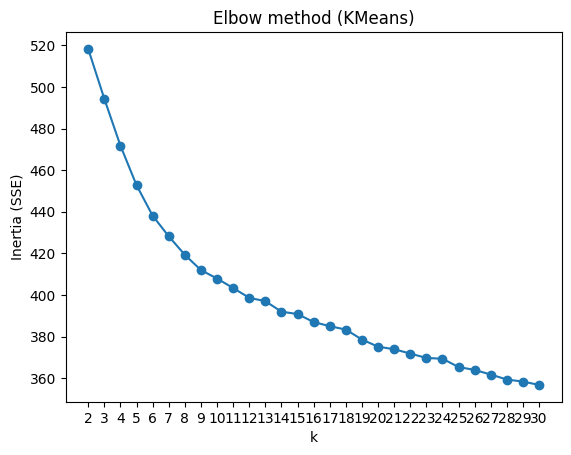

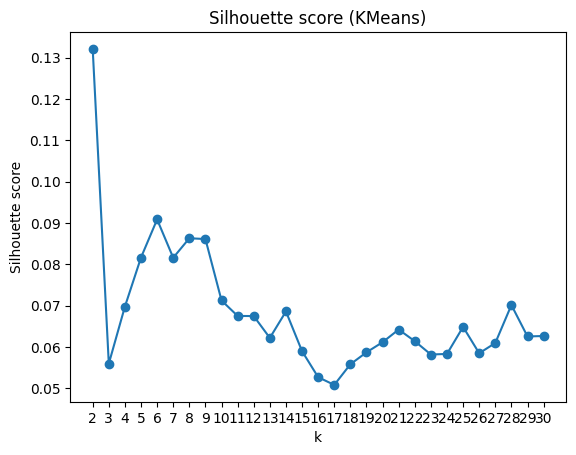


--- TOP 3 K (SILHOUETTE) ---
k = 2. score = 0.1321
k = 6. score = 0.0908
k = 8. score = 0.0863


In [299]:
ks, inertias, sils = kmeans_elbow_silhouette(
    X,                 
    k_min=2,
    k_max=30,
    random_state=42,
    n_init=10,
    sample_size_for_silhouette=None 
)

# --- PLOT ELBOW ---
plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow method (KMeans)")
plt.xticks(ks)
plt.show()

# --- PLOT SILHOUETTE ---
plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score (KMeans)")
plt.xticks(ks)
plt.show()

top_indices = np.argsort(sils)[::-1]

print("\n--- TOP 3 K (SILHOUETTE) ---")
for i in range(3):
    idx = top_indices[i]
    print(f"k = {ks[idx]}. score = {sils[idx]:.4f}")

In [300]:

from sklearn.pipeline import make_pipeline

n_components = 30

pca = PCA(n_components=n_components, random_state=42)
normalizer = Normalizer(copy=False) 
pca_pipeline = make_pipeline(pca, normalizer)
X_pca = pca_pipeline.fit_transform(X)

var_explained = pca.explained_variance_ratio_.sum()
print(f"PCA n_components: {n_components}. Variance Explained: {var_explained:.2%}")

PCA n_components: 30. Variance Explained: 61.41%


In [301]:
k = 9
print(f"Clustering with K={k}...")

kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
trans_labels = kmeans.fit_predict(X_pca)

baseline_score = silhouette_score(X_pca, trans_labels)

print(f"BASELINE SCORE (TRANSFORMER): {baseline_score:.4f}")


Clustering with K=9...
BASELINE SCORE (TRANSFORMER): 0.1743


# Results

In [302]:

rows1 = []
for i, d in enumerate(docs):
    rows1.append({
        "ID": i,
        "TARGET": int(tfidf_labels[i])+1
    })

rows2 = []
for i, d in enumerate(docs):
    rows2.append({
        "ID": i,
        "TARGET": int(trans_labels[i])+1
    })

df = pd.DataFrame(rows1)
df.to_csv("book_clusters_tfidf.csv", index=False, encoding="utf-8")

df = pd.DataFrame(rows2)
df.to_csv("book_clusters_transformer.csv", index=False, encoding="utf-8")

df.head()

,ID,TARGET
0,0,3
1,1,6
2,2,2
3,3,2
4,4,2
